In [42]:
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [43]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [44]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [45]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [46]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

In [47]:
#save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]

#usable_columns = list(set(train.columns) - set(['y']))

y_train = train['y'].values
y_mean = np.mean(y_train)
id_test = test['ID'].values
#finaltrainset and finaltestset are data to be used only the stacked model (does not contain PCA, SVD... arrays) 
finaltrainset = train[usable_columns].values
finaltestset = test[usable_columns].values

In [48]:
'''Train the xgb model then predict the test data'''

xgb_params = {
    'n_trees': 520, 
    'eta': 0.0045,
    'max_depth': 4,
    'subsample': 0.93,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}
# NOTE: Make sure that the class is labeled 'class' in the data file

dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

num_boost_rounds = 1250
# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[07:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[07:54:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[07:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[07:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

In [49]:
# from sklearn.model_selection import train_test_split
# _, X_test, _, y_test = train_test_split(train.drop('y', axis=1), y_train, test_size=0.2, random_state=1729)

# xgbr = xgb.XGBRegressor(learning_rate =0.01,
#                         n_estimators=100,
#                         max_depth=8,
#                         min_child_weight=1,
#                         gamma=0.4,
#                         subsample=0.75,
#                         colsample_bytree=0.8,
#                         objective= 'reg:linear',
#                         n_jobs=-1,
#                         scale_pos_weight=1,
#                         seed=50,
#                         verbose=1)
# xgbr.fit(train.drop('y', axis=1), y_train, eval_set = [(X_test, y_test)],early_stopping_rounds=100)
# # 计算 auc 分数、预测
# # preds = xgbr.predict(X_test)

# # grid_search = GridSearchCV(xgbr, param_grid=xgbr_params,cv=10)
# # grid_result = grid_search.fit(X_train, y_train)
# # xgbr_best = grid_search.best_estimator_
# # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # y_pred = xgbr_best.predict(dtest)

In [50]:
'''Train the stacked models then predict the test data'''

stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, min_samples_leaf=18, min_samples_split=14, subsample=0.7)),
    LassoLarsCV()
)


stacked_pipeline.fit(finaltrainset, y_train)
results = stacked_pipeline.predict(finaltestset)

In [51]:
'''R2 Score on the entire Train data when averaging'''
# 0.6588147924393625
print('R2 score on train data:')
print(r2_score(y_train,stacked_pipeline.predict(finaltrainset)*0.2855 + model.predict(dtrain)*0.7145))

R2 score on train data:
0.48103673217690157


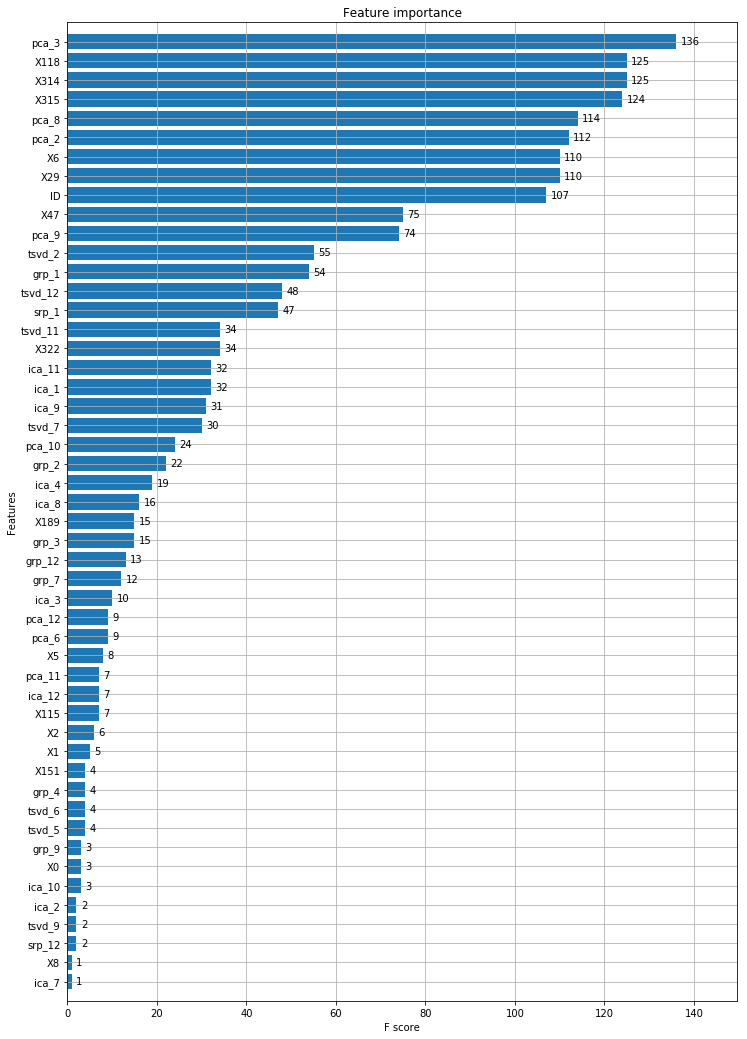

In [52]:
import matplotlib.pyplot as plt
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [53]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred*0.75 + results*0.25
sub.to_csv('stacked-models.csv', index=False)
# Any results you write to the current directory are saved as output.

In [54]:
# '''R2 Score on the entire Train data when averaging'''
# print('R2 score on train data:')
# print(r2_score(y_train, stacked_pipeline.predict(finaltrainset)*0.2855 + xgbr.predict(train.drop('y', axis=1))*0.7145))